In [ ]:
pip install -q -U tensorflow_addons

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import ipyplot as plt2
import seaborn as sns
from tensorflow.keras.datasets import mnist
import pandas as pd

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255, x_test/255
rad2deg = 180/np.pi

train_morpho = pd.read_csv("train-morpho.csv")
test_morpho = pd.read_csv("t10k-morpho.csv")
train_morpho['slant'] = train_morpho['slant'].map(lambda x: x*rad2deg)
test_morpho['slant'] = test_morpho['slant'].map(lambda x: x*rad2deg)


2023-05-22 16:02:04.469867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 16:02:04.526733: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 16:02:04.527506: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 16:02:06.090950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# EDA

In [ ]:
display(train_morpho)

In [ ]:
plt2.plot_class_tabs(x_train, y_train, img_width=28, show_url=False, zoom_scale=3)

In [ ]:
plt.figure()
plt.hist(y_train, rwidth=0.8)
plt.show()

In [ ]:
fig, axes = plt.subplots(5, 2, )
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_tight_layout(True)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        axes[i, j].hist(train_morpho['slant'][y_train==(2*i+j)])
        axes[i,j].set_title((2*i+j))
        
plt.show()

In [ ]:
class_mean_x = [np.mean(x_train[y_train==i], (0)) for i in range(10)]
plt2.plot_images(class_mean_x)

In [ ]:
fig, axes = plt.subplots(5, 2, )
fig.set_figwidth(10)
fig.set_figheight(15)
fig.set_tight_layout(True)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        slants = train_morpho["slant"][y_train==(2*i+j)]
        axes[i, j].violinplot(slants)
        axes[i,j].set_title(f"{2*i+j} mean: {np.round(np.mean(slants), 4)}")
        axes[i,j].set_ylim(bottom=-1.1, top=1.1)
        
plt.show()

Muchos de los numeros tienen distribuciones muy similares en el slant, ademas hay bastante dispersion.

In [ ]:
plt.figure()
corr_matrix = train_morpho.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

La mayor correlacion con el slant la comparte el width. De todas formas es relativamente baja

# Model training

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
from helper import *
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras import optimizers as opt
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Embedding, Concatenate, Input, Normalization
from tensorflow.keras import Sequential, Model
from tensorflow_addons.optimizers import CyclicalLearningRate, Triangular2CyclicalLearningRate, TriangularCyclicalLearningRate


metrics=['mean_squared_error']

#keras.utils.set_random_seed(hash("Los buenos caballos y los buenos estudiantes siempre terminan su carrera.") % 2**32)


width_mean = train_morpho["width"].mean()
width_std = train_morpho["width"].std()
if np.abs(width_mean) > 1:
    train_morpho["width"] = train_morpho["width"].apply(lambda x: (x-width_mean)/width_std)
    print(train_morpho["width"])

0        0.374996
1        0.592000
2        1.894646
3       -1.973877
4        0.051593
           ...   
59995   -0.315463
59996    0.064515
59997    0.271110
59998    0.557246
59999    0.087415
Name: width, Length: 60000, dtype: float64


/home/gullino18/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [22]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(1))

clr = Triangular2CyclicalLearningRate(5e-5, 0.01, 5 * 196)

model.compile(optimizer=opt.Adamax(clr), loss='MAE')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 784)               0         
                                                                 
 dense_24 (Dense)            (None, 100)               78500     
                                                                 
 dense_25 (Dense)            (None, 100)               10100     
                                                                 
 dense_26 (Dense)            (None, 1)                 101       
                                                                 
Total params: 88,701
Trainable params: 88,701
Non-trainable params: 0
_________________________________________________________________


In [23]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, min_lr=5e-9, patience=5)

history = model.fit(x=x_train, y=train_morpho["slant"], batch_size=256, epochs=1000, validation_data=(x_test, test_morpho["slant"]), callbacks=[earlyStopCB, LearningSchedulerCB])

Epoch 1/1000
235/235 [==============================] - 3s 7ms/step - loss: 9.5266 - val_loss: 4.3583 - lr: 0.0024
Epoch 2/1000
235/235 [==============================] - 2s 8ms/step - loss: 2.1040 - val_loss: 0.7530 - lr: 0.0048
Epoch 3/1000
235/235 [==============================] - 1s 6ms/step - loss: 0.5988 - val_loss: 0.4279 - lr: 0.0072
Epoch 4/1000
235/235 [==============================] - 2s 7ms/step - loss: 0.4522 - val_loss: 0.3460 - lr: 0.0096
Epoch 5/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.3406 - val_loss: 0.4442 - lr: 0.0080
Epoch 6/1000
235/235 [==============================] - 2s 7ms/step - loss: 0.2791 - val_loss: 0.2446 - lr: 0.0056
Epoch 7/1000
235/235 [==============================] - 1s 6ms/step - loss: 0.2177 - val_loss: 0.1943 - lr: 0.0033
Epoch 8/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.1843 - val_loss: 0.1692 - lr: 8.7240e-04
Epoch 9/1000
235/235 [==============================] - 2s 7ms/step - loss: 

In [6]:
input_img = Input((28, 28))
input_width = Input(1,)
flatten = Flatten()(input_img)
concat = Concatenate()([flatten, input_width])
dense = Dense(100, activation='sigmoid')(concat)
dense = Dense(100, activation='sigmoid')(dense)

out = Dense(1)(dense)
    
model = Model([input_img, input_width], out)

clr = Triangular2CyclicalLearningRate(5e-6, 0.01, 5 * 196)

model.compile(optimizer=opt.Adamax(clr), loss='mae')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 784)          0           ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 785)          0           ['flatten_2[0][0]',              
                                                                  'input_4[0][0]']          

In [ ]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, min_lr=5e-9, patience=5)

history = model.fit(x=[x_train, train_morpho["width"]], y=train_morpho["slant"], batch_size=256, epochs=1000, validation_data=([x_test, test_morpho["width"]], test_morpho["slant"]), callbacks=[earlyStopCB, LearningSchedulerCB])

In [18]:

input_img = Input((28, 28))
input_lbl = Input(1,)
flatten = Flatten()(input_img)
embed = Embedding(10, 2, input_length=1)(input_lbl)
embed = Flatten()(embed)
concat = Concatenate()([flatten, embed])
dense = Dense(100, activation='sigmoid')(concat)
dense = Dense(100, activation='sigmoid')(dense)

out = Dense(1)(dense)
    
model = Model([input_img, input_lbl], out)

clr = Triangular2CyclicalLearningRate(1e-7, 0.01, 7 * 235)

model.compile(optimizer=opt.Adamax(0.01), loss='mae')
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 2)         20          ['input_16[0][0]']               
                                                                                                  
 flatten_14 (Flatten)           (None, 784)          0           ['input_15[0][0]']               
                                                                                            

In [20]:
earlyStopCB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
LearningSchedulerCB = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, min_lr=5e-9, patience=5)

history = model.fit(x=[x_train, y_train], y=train_morpho["slant"], batch_size=256, epochs=1000, validation_data=([x_test, y_test], test_morpho["slant"]), callbacks=[earlyStopCB, LearningSchedulerCB])

Epoch 1/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.0366 - val_loss: 0.0689 - lr: 3.0518e-07
Epoch 2/1000
235/235 [==============================] - 2s 7ms/step - loss: 0.0366 - val_loss: 0.0689 - lr: 3.0518e-07
Epoch 3/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.0366 - val_loss: 0.0689 - lr: 3.0518e-07
Epoch 4/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.0366 - val_loss: 0.0689 - lr: 3.0518e-07
Epoch 5/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.0366 - val_loss: 0.0689 - lr: 3.0518e-07
Epoch 6/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.0366 - val_loss: 0.0689 - lr: 3.0518e-07
Epoch 7/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.0366 - val_loss: 0.0689 - lr: 1.5259e-07
Epoch 8/1000
235/235 [==============================] - 2s 8ms/step - loss: 0.0366 - val_loss: 0.0689 - lr: 1.5259e-07
Epoch 9/1000
235/235 [==========================

1/1 [==============================] - 0s 78ms/step
[[ 0.02085415  0.17724985]
 [ 0.02737473  0.02921362]
 [ 0.03064269  0.22574167]
 [-0.12009954 -0.05617594]
 [ 0.22011946 -0.03089738]
 [-0.1806078  -0.01468826]
 [ 0.12414286  0.00699845]
 [ 0.04245999  0.05330601]
 [-0.1120777   0.05676164]
 [-0.0275183  -0.06000678]]


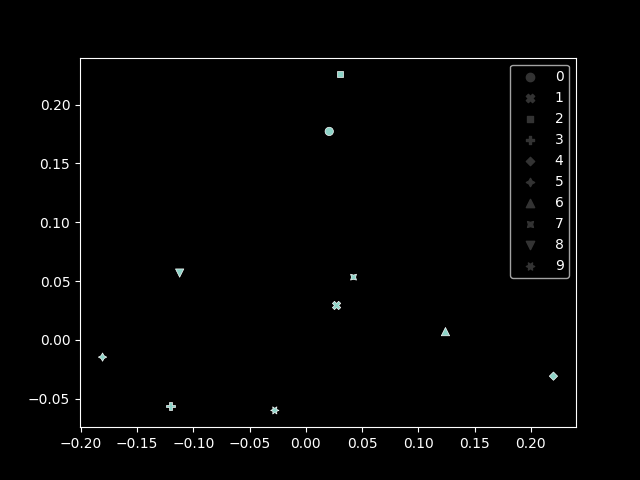

313/313 [==============================] - 1s 3ms/step
[[ 4.0721645]
 [-9.941828 ]
 [16.611761 ]
 ...
 [11.211183 ]
 [30.404066 ]
 [ 7.663029 ]]
      index      area     length  thickness      slant      width     height
0         0   71.1875  36.256097   2.110571   4.066199  15.124338  19.620730
1         1  113.0625  43.548990   2.650075  -9.962917  17.593875  19.846226
2         2   39.2500  22.545942   1.866641  16.638250   3.679712  19.704668
3         3  146.8125  45.248737   3.480516   4.146705  14.712746  19.033061
4         4   75.2500  44.170310   1.951528  -7.378214  14.919511  18.791649
...     ...       ...        ...        ...        ...        ...        ...
9995   9995  152.8750  41.334524   3.838383  -1.446727  16.036384  19.346895
9996   9996  134.6250  45.827164   3.381650  -4.309251  14.640758  19.473707
9997   9997  114.4375  41.688077   3.254806  11.246739  11.688326  19.358837
9998   9998  104.0625  42.091883   2.651545  30.389567  15.171153  14.680493
9999   9

In [21]:
aver_adentro = Model(input_lbl, embed)
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
lindo = aver_adentro.predict(labels)
print(lindo)
plt.figure()
x, y = lindo.T
sns.scatterplot(x=x, y=y, style=labels)

plt.show()
aver = model.predict([x_test, y_test/10])
print(aver)
print(test_morpho)